# This is a basic Starter Kernel for the New York City Taxi Fare Prediction Playground Competition 
Here we'll use a simple linear model based on the travel vector from the taxi's pickup location to dropoff location which predicts the `fare_amount` of each ride.

This kernel uses some `pandas` and mostly `numpy` for the critical work.  There are many higher-level libraries you could use instead, for example `sklearn` or `statsmodels`.  

In [1]:
# Initial Python environment setup...
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to

print(os.listdir('./all'))

['GCP-Coupons-Instructions.rtf', 'sample_submission.csv', 'test.csv', 'train.csv']


### Setup training data
First let's read in our training data.  Kernels do not yet support enough memory to load the whole dataset at once, at least using `pd.read_csv`.  The entire dataset is about 55M rows, so we're skipping a good portion of the data, but it's certainly possible to build a model using all the data.

In [2]:

train_df =  pd.read_csv('./all/train.csv', nrows=1_000_000)
train_df['pickup_datetime'] =  pd.to_datetime(train_df['pickup_datetime'], infer_datetime_format=True)
train_df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

### Explore and prune outliers
First let's see if there are any `NaN`s in the dataset.

In [3]:
#print(train_df.isnull().sum())

In order to prune dirty pickup and drop locations, we need to first create a boundary of NYC.
Any entry with GPS coordinates not lying within this boundary must be eliminated.

Since actual boundary of NYC will be a gross polygon, and checking if our entry is inside it will become difficult, let's just imagine a rectangular boundary for the sake of simplicity.

Find the boundaries of pickup and drop locations from `test_data` 

In [4]:

test_df = pd.read_csv('./all/test.csv')
test_df.pickup_datetime = test_df.pickup_datetime.apply(pd.to_datetime)
print(test_df.dtypes)
max_long = -73.684040 
max_lat = 40.992311
min_long = -74.204389
min_lat = 40.496615
print("max long: %f" % max_long)
print("max lat: %f" % max_lat)
print("min long: %f" % min_long)
print("min lat: %f" % min_lat)

key                          object
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object
max long: -73.684040
max lat: 40.992311
min long: -74.204389
min lat: 40.496615


There are a small amount, so let's remove them from the dataset.
Also remove those elements that fall beyond the max

In [5]:

print('Old size before eliminating NaNs: %d' % len(train_df))
#train_df = train_df.dropna(how = 'any', axis = 'rows')
#print('New size after eliminating NaNs: %d' % len(train_df))
train_df = train_df[((train_df.pickup_latitude.between(min_lat,max_lat)) &
                     (train_df.pickup_longitude.between(min_long,max_long)) &
                     (train_df.dropoff_latitude.between(min_lat,max_lat)) &
                     (train_df.dropoff_longitude.between(min_long,max_long)) &
                     (train_df.passenger_count.between(1,6)) &
                     (train_df.fare_amount > 0))]
print('New size after eliminating locations outside boundary: %d' % len(train_df))

Old size before eliminating NaNs: 1000000
New size after eliminating locations outside boundary: 974494


Now let's quickly plot a subset of our travel vector features to see its distribution.

Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates.  We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.

In [6]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [7]:
train_df['total_displacement'] = (train_df['abs_diff_longitude'] + train_df['abs_diff_latitude']) 
plot = train_df.plot.scatter('total_displacement','fare_amount',c='#0000FF')

In the above graph, we see for displacement as low as 0.0-0.01 is resulting in fares higher than 60 dollars.
This either means that the route between source and destination is too far apart or else it's an anomaly.
In either case, it must be eliminated.

To and fro JFK/Manhattan has a flat charge of 52 dollars as per http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml, meaning a 0.016 difference in displacement (1.15 miles) should not levy more than 2-3 dollars over the base fare. Overall, to be safe, the fare shouldn't be more than 55 dollars for 0.016 displacement. 

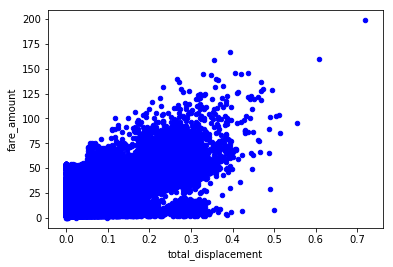

In [8]:
train_df = train_df[(train_df.total_displacement > 0.05) | (train_df.fare_amount < 55)]
train_df = train_df[(train_df.total_displacement > 0.1) | (train_df.fare_amount < 80)]
plot = train_df.plot.scatter('total_displacement','fare_amount',c='#0000FF')

Similarly, for displacement 0.2 (13.8 miles) the minimum fare would at least be 37 dollars. But since we see a good amount of fares for displacement 0.2, we can at least eliminate entries less than 20 dollars. 

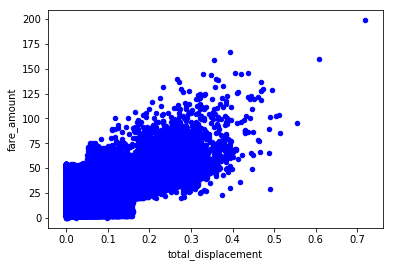

In [9]:
train_df = train_df[(train_df.total_displacement < 0.16) | (train_df.fare_amount > 20)]
plot = train_df.plot.scatter('total_displacement','fare_amount',c='#0000FF')

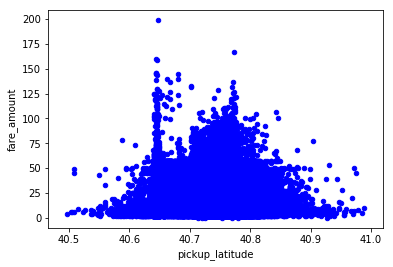

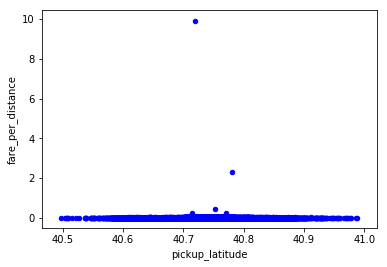

In [10]:
train_df['fare_per_distance'] = train_df['total_displacement'] / train_df['fare_amount']
plot = train_df.plot.scatter('pickup_latitude','fare_amount',c='#0000FF')
plot = train_df.plot.scatter('pickup_latitude','fare_per_distance',c='#0000FF')

fare per distance(i.e fare per unit displacement) seems to be as high as 0.20 for few points.
Clear winners of being outliers, must be rewarded with elimination.

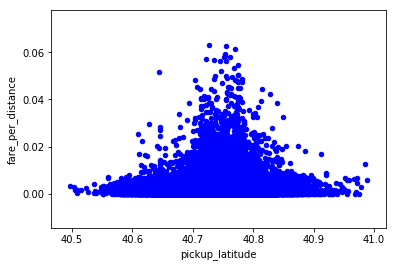

In [11]:
train_df = train_df[train_df.fare_per_distance < 0.10]
plot = train_df.plot.scatter('pickup_latitude','fare_per_distance',c='#0000FF')

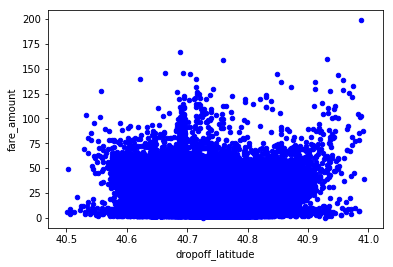

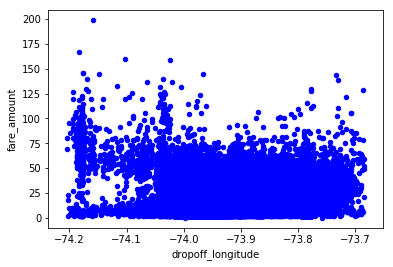

In [12]:
plot = train_df.plot.scatter('dropoff_latitude','fare_amount',c='#0000FF')
plot = train_df.plot.scatter('dropoff_longitude','fare_amount',c='#0000FF')

The dropoff longitude at around -74.2 has a very high fare.
That longitude corresponds to Newark airport, which also incurs a surcharge of 17.5 dollars.
You won't see the same high fare rate while passenger is picked up at Newark because the surcharge is only applicable on dropoff. 

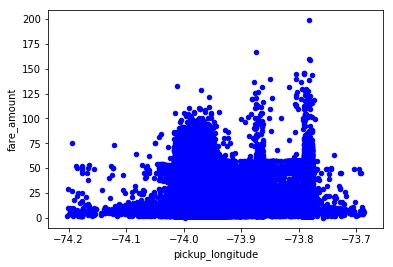

In [13]:
plot = train_df.plot.scatter('pickup_longitude','fare_amount',c='#0000FF')

Here at pickup longitude, instead of Newark, the longitude near JFK and Manhattan have a very high fare. Same can be said when they're at dropoff locations.

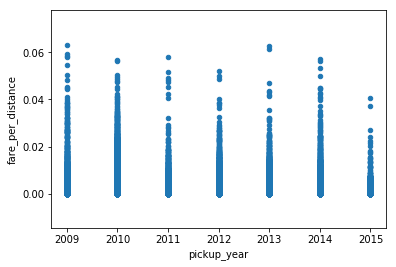

In [14]:
train_df['pickup_datetime_num'] = train_df.pickup_datetime.dt.hour + train_df.pickup_datetime.dt.minute/60 + train_df.pickup_datetime.dt.second/60
train_df['pickup_year'] = train_df.pickup_datetime.dt.year
train_df = train_df[(train_df.fare_per_distance <= 0.4)]
plot = train_df.plot.scatter('pickup_year','fare_per_distance')

In year wise distribution, every year a few fares seem to be way out of the norm.
Seems safe to remove those having fare_per_distance greater than 0.4

In [15]:
#train_df = train_df[(train_df.fare_per_distance <= 0.4)]
#train_df['pickup_year'] = train_df.pickup_datetime.dt.year
#plot = train_df.plot.scatter('pickup_year','fare_per_distance')
#train_df.pickup_year.dtypes

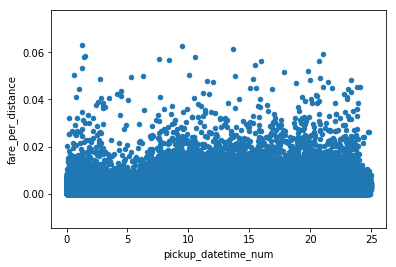

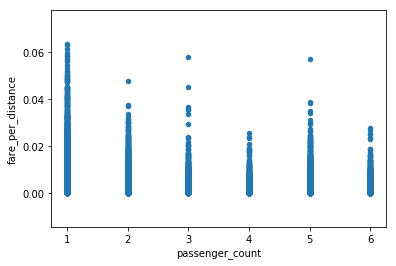

In [16]:
plot = train_df.plot.scatter('pickup_datetime_num','fare_per_distance')
plot = train_df.plot.scatter('passenger_count','fare_per_distance')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city.  For reference, one degree of latitude is about 69 miles.  However, we can see the dataset has extreme values which do not make sense.  Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 2000 rows...)

In [17]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 2.0) & (train_df.abs_diff_latitude < 2.0)]
print('New size: %d' % len(train_df))

Old size: 973126
New size: 973126


### Train our model
Our model will take the form $X \cdot w = y$ where $X$ is a matrix of input features, and $y$ is a column of the target variable, `fare_amount`, for each row. The weight column $w$ is what we will "learn".

First let's setup our input matrix $X$ and target column $y$ from our training set.  The matrix $X$ should consist of the two GPS coordinate differences, plus a third term of 1 to allow the model to learn a constant bias term.  The column $y$ should consist of the target `fare_amount` values.

In [18]:
# Construct and return an Nx3 input matrix for our linear model
# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude,
                            df.abs_diff_latitude,
                            df.pickup_latitude,
                            df.pickup_longitude,
                            df.dropoff_latitude,
                            df.dropoff_longitude,
                            df.pickup_datetime.dt.year,
                            df.pickup_datetime.dt.hour + df.pickup_datetime.dt.minute/60 + df.pickup_datetime.dt.second/60, 
                            df.passenger_count,
                            np.ones(len(df))))

train_X = get_input_matrix(train_df)
train_y = np.array(train_df.fare_amount)

print(train_X.shape)
print(train_y.shape)

(973126, 10)
(973126,)


Now let's use `numpy`'s `lstsq` library function to find the optimal weight column $w$.

In [19]:
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[ 1.76218818e+02  1.42870416e+02  7.62823482e+00  1.16122811e+01
 -1.82681936e+01 -5.87154577e+00  4.71336117e-01  9.12432993e-03
  3.67311185e-02 -8.58684356e+01]


These weights pass a quick sanity check, since we'd expect the first two values -- the weights for the absolute longitude and latitude differences -- to be positive, as more distance should imply a higher fare, and we'd expect the bias term to loosely represent the cost of a very short ride.

Sidenote:  we can actually calculate the weight column $w$ directly using the [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) method:
$w = (X^T \cdot X)^{-1} \cdot X^T \cdot y$

In [20]:
#w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(train_X.T, train_X)), train_X.T), train_y)
#print(w_OLS)

### Make predictions on the test set
Now let's load up our test inputs and predict the `fare_amount`s for them using our learned weights!

In [21]:
#test_df = pd.read_csv('./all/test.csv')
#print(test_df.dtypes)


In [22]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)
# Predict fare_amount on the test set using our model (w) trained on the training set.
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)

print(os.listdir('.'))

['.ipynb_checkpoints', 'all', 'debug.log', 'kernel.ipynb', 'rushabh-kernel (1).ipynb', 'submission.csv', 'Untitled.ipynb']
